# Trajectory Inference

Using TI methods with dyno for pseudotime like analyses.

In [ ]:
library(tidyverse)
library(dyno)
library(reshape2)
library(viridis)
library(scales)

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

In [3]:
dat = read.table("../20200206_pmat_snapATAC/sessions/20200217_n71173/features.tsv", 
            sep='\t')

In [5]:
head(dat, 2)

,x.sp.sample,umap.1,umap.2,x.sp.cluster,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D0_AAACACGCTCCTCAAA,D0,-4.776449,6.775422,1,-0.01268978,0.005993608,-0.002581500,-0.009445956,0.025808250,-0.015638919,0.006602783,-0.014001531,0.001956239,-0.003254753,0.003061602,0.0231355842
D0_AAACACGCTGATCCAT,D0,-2.090132,9.319737,8,-0.01196450,0.004300920,-0.004145458,-0.006050338,-0.002013348,-0.001228813,-0.005791189,0.006896094,0.007019901,0.008717369,-0.009700307,-0.0002939505


In [6]:
# remove doublets cluster
dat = dat[dat$x.sp.cluster!=18,]
dim(dat)

[1] 69534    16

In [7]:
# Take same number of cells from each day
fewest = min(table(dat$x.sp.sample))
idxs = c()

for (d in DAYS) {
    idxs = c(idxs, sample(which(dat$x.sp.sample==d), fewest))
}

dat_red = dat[idxs, ]

In [8]:
table(dat_red[, "x.sp.sample"])


  D0  D10  D12  D14   D2   D4   D6   D8 
3835 3835 3835 3835 3835 3835 3835 3835 

In [9]:
# idxs = sample(seq(1,nrow(dat)), 10000)
dataset <- wrap_expression(
  expression =  as.matrix(dat_red[,5:ncol(dat)]),
  counts = as.matrix(dat_red[,5:ncol(dat)])
)

In [10]:
head(sort(rownames(dat_red)))

[1] "D0_AAACAACGACGATTAC" "D0_AAACAACGAGCGCACT" "D0_AAACACGCTAGGTAAT"
[4] "D0_AAACACGCTCCTCAAA" "D0_AAACACGCTCTTCAAG" "D0_AAACACGCTGATCCAT"

In [11]:
dataset <- add_prior_information(dataset, start_id = "D0_AAACAACGACGATTAC")

In [132]:
model <- infer_trajectory(dataset, ti_paga_tree(filter_features = F, 
                                          n_neighbors = 15L,
                                          n_comps = 12L,
#                                           n_dcs = 0L,
                                          embedding_type="umap"))

In [12]:
# model <- infer_trajectory(dataset, ti_mst(dimred="umap",
#                                           ndim=2))

Loading required namespace: hdf5r



In [13]:
# plot_dimred(model, "pseudotime",
#             dimred = -as.matrix(dat[,c("umap.1", "umap.2")]),
#             size_cells = 0.1,
#             label_milestones = T)

In [176]:
# plot_dendro(model, grouping = dat[, "x.sp.sample"])

Coloring by grouping



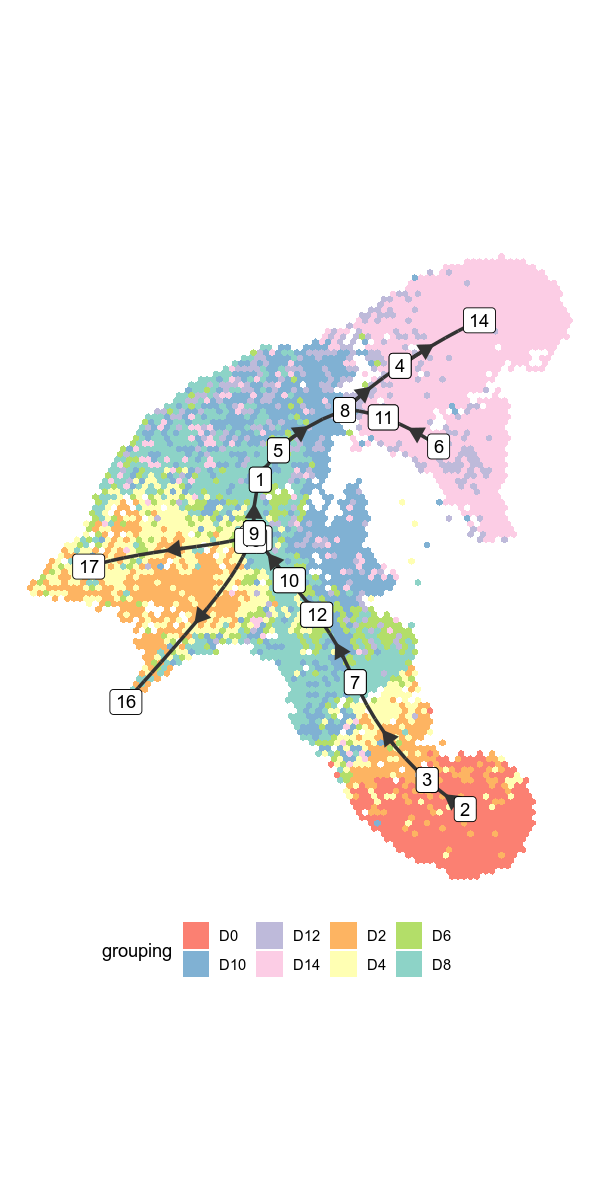

In [133]:
plot_dimred(model, dimred = -as.matrix(dat_red[,c("umap.1", "umap.2")]),
            size_cells = 0.1,
            grouping = dat_red[, "x.sp.sample"],
            label_milestones = T)

In [134]:
simplified <- simplify_trajectory(model)
simplified <- simplified %>% add_root(root_milestone_id = "2")

Coloring by grouping



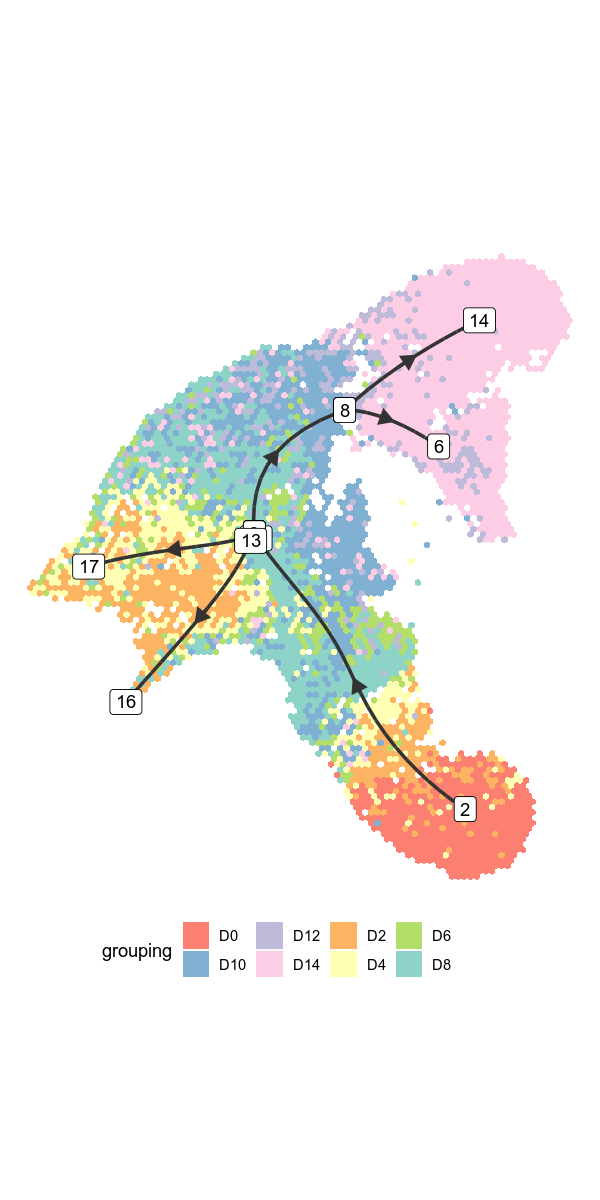

In [141]:
plot_dimred(simplified, dimred = -as.matrix(dat_red[,c("umap.1", "umap.2")]),
            size_cells = 0.1,
            grouping = dat_red[, "x.sp.sample"],
            label_milestones = T)

In [142]:
table(simplified$progressions$from)


    2     8     9 
10457  7513 12710 

Paths:
- To pluripotency are 2 -> 9 -> 8 -> 14
- To keratinocyte are 
- To neural like  are 

In [137]:
pluripotency_paths = c("2_9", "9_8", "8_14")

In [138]:
plu_cells = simplified$progressions[paste(simplified$progressions$from, 
                                   simplified$progressions$to,
                                   sep = '_') %in% pluripotency_paths,]
head(plu_cells)
dim(plu_cells)

,cell_id,from,to,percentage
,<chr>,<chr>,<chr>,<dbl>
5205,D2_GTACATCGATAGGCGA,9,8,0.4228785
5206,D2_CAAACCTGAAGGGCTA,9,8,0.4157569
5207,D2_ACTGTGATGCTGGGTC,9,8,0.4812823
5208,D2_AAGCGCCACGGCCTGT,9,8,0.4450695
5209,D2_TATCTCCCTTACCTGA,9,8,0.4182663
5210,D2_TTGTGCGCTGAAATCA,9,8,0.4081457


[1] 22073     4

In [143]:
# sort by order and then by percentage
plu_cells = plu_cells[order(factor(paste(plu_cells$from, 
                                        plu_cells$to, 
                                        sep='_'), 
                                  levels=pluripotency_paths), 
                           plu_cells$percentage), ]
head(plu_cells)

,cell_id,from,to,percentage
,<chr>,<chr>,<chr>,<dbl>
14785,D0_AAACAACGACGATTAC,2,9,0.000000000
12881,D0_AGATCCTGACATGCAT,2,9,0.002351678
14029,D0_AACGCGCTGGCTGGCT,2,9,0.002545255
12944,D0_CGTCAACCTCACAGTT,2,9,0.002958251
13988,D0_ATCAAGCACCTATCTT,2,9,0.002960845
13513,D0_ACGGCCATGCGGAATG,2,9,0.002975990


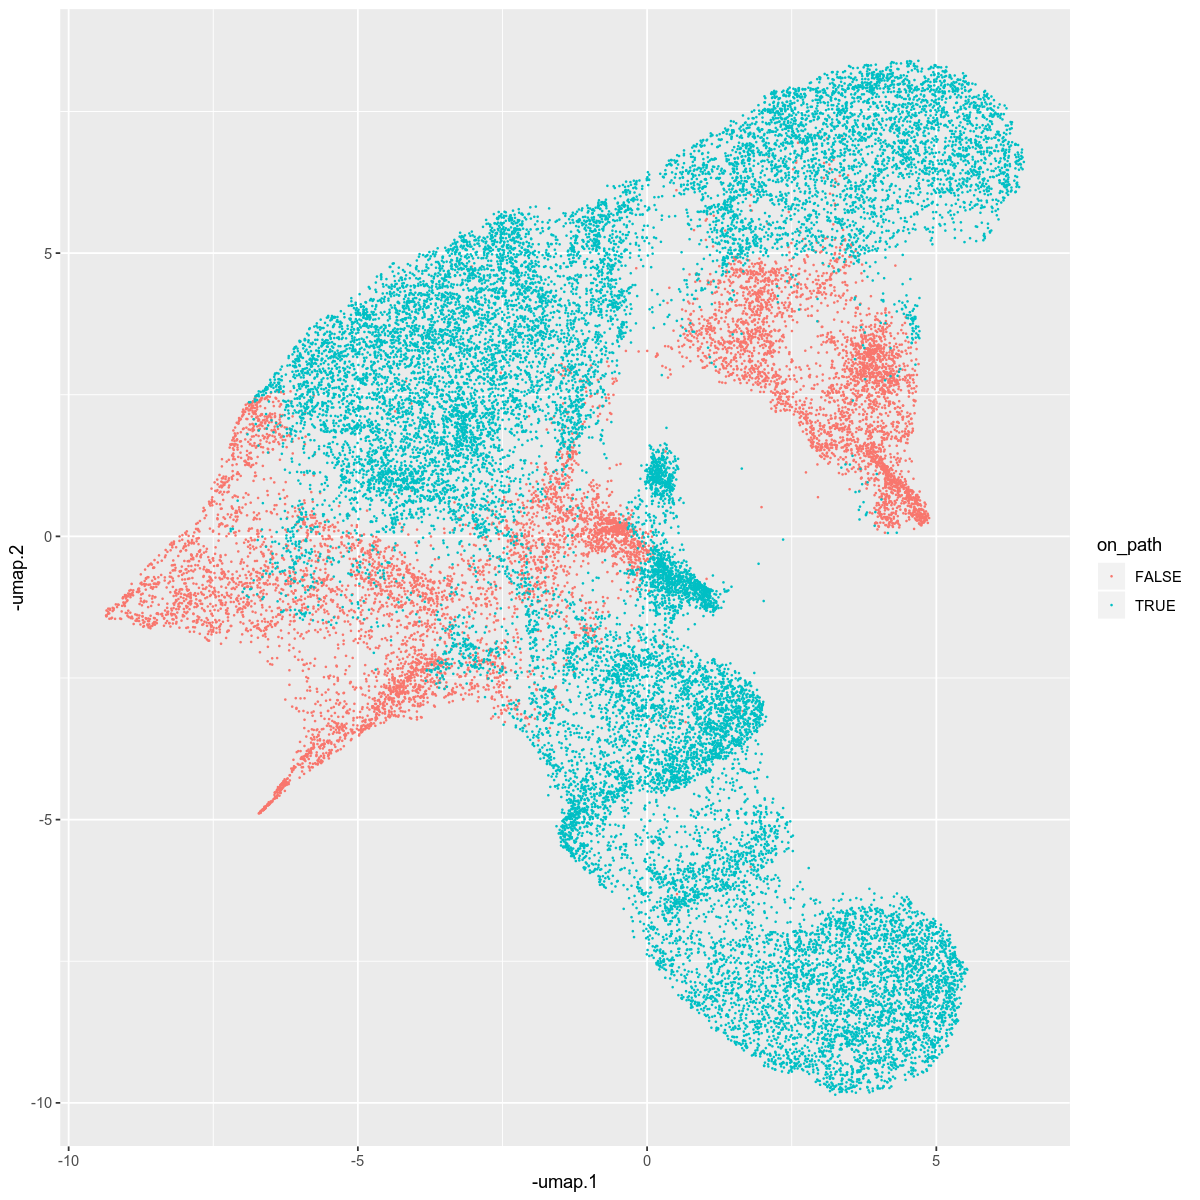

In [253]:
options(repr.plot.width = 10, repr.plot.height = 10)
df = dat_red
df$on_path = rownames(df) %in% plu_cells$cell_id
df = df[order(df$on_path),]

ggplot(data=df,aes(x=-umap.1,y=-umap.2,color=on_path))+
scale_fill_viridis() +
geom_point(size=0.1)

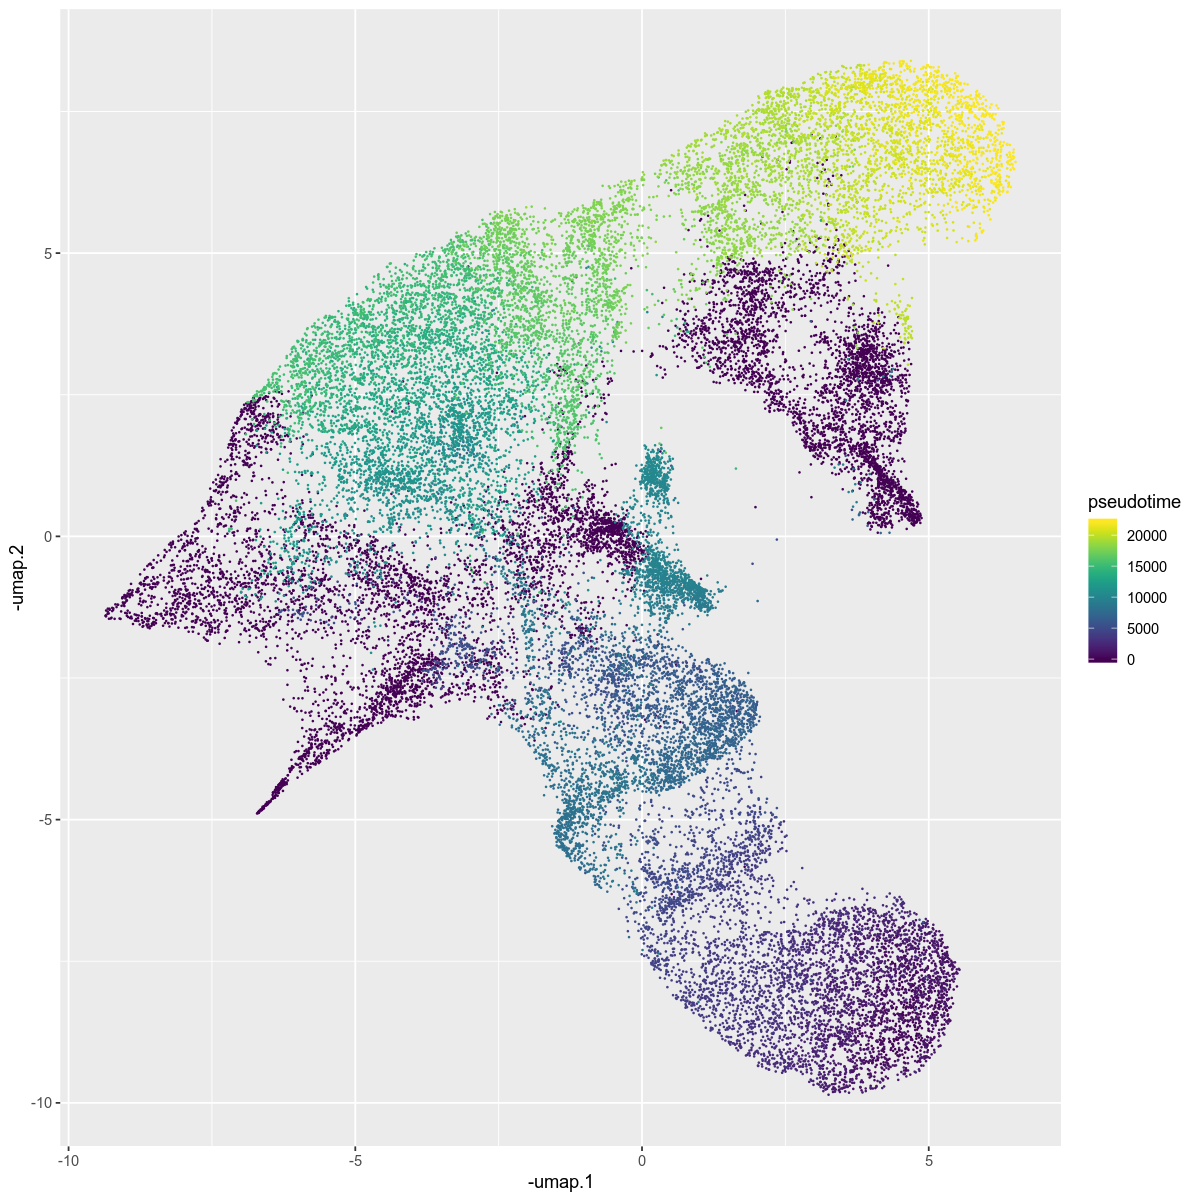

In [144]:
options(repr.plot.width = 10, repr.plot.height = 10)
df = dat_red
df$pseudotime = 0
df[plu_cells$cell_id, "pseudotime"] = seq(1,nrow(plu_cells))
df = df[order(df$pseudotime),]

ggplot(data=df,aes(x=-umap.1,y=-umap.2,color=pseudotime))+
scale_color_viridis() +
geom_point(size=0.1)

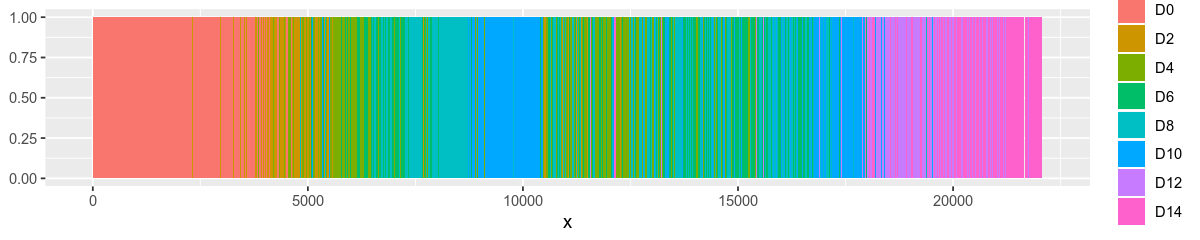

In [259]:
options(repr.plot.width = 10, repr.plot.height = 2)

cur_df = data.frame(x=seq(1,nrow(plu_cells)),
                    d=factor(dat_red[plu_cells$cell_id, "x.sp.sample"],
                            levels=DAYS))
ggplot(cur_df) +
geom_col(aes(x=x, y=1, fill=d),  width=1) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ylab(NULL)

## ChromVAR ordered

In [61]:
chromvar = read.table(gzfile("../20200206_pmat_snapATAC/sessions/20200217_n71173/chromvar.tsv.gz"), 
                      sep='\t')
head(chromvar)

In [185]:
motif_df = t(chromvar[plu_cells$cell_id,5:ncol(chromvar)])
head(motif_df)

,D0_AAACAACGACGATTAC,D0_AGATCCTGACATGCAT,D0_AACGCGCTGGCTGGCT,D0_CGTCAACCTCACAGTT,D0_ATCAAGCACCTATCTT,D0_ACGGCCATGCGGAATG,D0_GTTGAAGCTAAATCGA,D0_GTCCCAGGACGAACAG,D0_GTTGAAGCTAATACAG,D0_TCTTGGCACCCAAGTT,⋯,D14_TCTGAGCCTGCCAGCT,D14_TCCCAGACTTTCGTTT,D14_AGATATGGAAAAGTAC,D14_TTGTAACCTCCTGTGG,D14_CCTCCTGCTTCGACAT,D14_ATGCAAAGATGACTCA,D14_TACTGTTTGACACCGC,D14_AGGCCAAGAGAGCCTC,D14_GCAAATCTGCGGTTTA,D14_CTAGAGACTGAGAGGG
NFIL3,-0.04605763,0.0006071235,-0.07657254,0.01606611,-0.108318856,-0.07921015,0.11901047,0.02830445,-0.11649471,-0.05127561,⋯,0.16273826,0.022588960,-0.066545158,0.184629648,0.019401516,-0.15817456,0.22679148,0.11163271,-0.05199930,-0.15551485
FOXF2,0.13548038,0.1013825982,0.14254397,0.04037359,0.093467748,0.15573831,0.15691710,0.00582258,0.13911068,0.11533156,⋯,0.16342716,-0.006903209,0.007628513,0.471975959,-0.066990173,0.12269131,0.14194709,0.22983837,0.04817724,0.12574004
FOXD1,0.12937383,0.0361160998,0.08780795,0.04141011,0.092917693,0.06432485,0.12292277,-0.05463079,0.18599678,0.26581064,⋯,0.11907185,-0.006760972,-0.032658228,0.230752320,0.050870183,0.31803224,0.28948680,0.33261906,0.39973048,0.35526144
IRF2,0.03171455,0.0066615912,0.08768500,0.08828285,-0.006006781,0.03854725,-0.02703468,0.06557390,0.06353867,0.10410765,⋯,-0.14060331,0.159984092,-0.003099795,0.109547943,-0.046537647,0.20529235,-0.05822133,0.13842218,0.13494803,0.10400064
MZF1,-0.02863805,-0.0489983224,-0.04105049,-0.05717578,-0.040487678,-0.02778775,-0.04692608,-0.04442100,-0.05786021,-0.04569143,⋯,-0.02025008,-0.002442899,0.013473115,-0.009900551,0.005267672,0.03269449,0.04203734,-0.02214272,-0.01980891,0.05434853
MZF1.var.2.,-0.07244034,0.0001367123,-0.07801221,0.02311897,-0.045942139,-0.05246042,-0.08965204,-0.04362179,-0.02822061,-0.01707241,⋯,-0.03615227,0.126605235,-0.039221885,0.276322409,0.115888075,0.25611498,-0.06084691,-0.04028477,0.09718587,0.18940178


In [186]:
# z-norm per cell (there seemed to be a trended bias such that most motifs at later days had higher motif scores)
motif_df = scale(motif_df)

# clip quantiles
clip <- function(x){
    quantiles <- quantile( x, c(.05, .95 ) )
    x[ x < quantiles[1] ] <- quantiles[1]
    x[ x > quantiles[2] ] <- quantiles[2]
    x
}

motif_df = t(apply(motif_df, 1, clip))

# scale to 0-1
motif_df = motif_df - apply(motif_df, 1, min)
motif_df = motif_df/apply(motif_df, 1,max)

In [187]:
# smooth
motif_df_smooth = t(apply(motif_df, 1, smooth))
colnames(motif_df_smooth) = colnames(motif_df)
motif_df = motif_df_smooth
dim(motif_df)

[1]   453 22073

In [260]:
# take subset
motif_df = motif_df[c("POU5F1", "SOX2", "KLF4", "ZBTB7B", "CTCF", "YY1", "TFAP2B", 
                     "BACH2", "JUNB", "FOXC2", "FOXB1", "ATF4", "JUN", "CEBPA") ,]

In [261]:
# order rows (motifs)
row_distance = dist(t(scale(t(motif_df))))
row_cluster = hclust(row_distance, method="ward")
row_dendrogram = as.dendrogram(row_cluster)
rowInd = rev(order.dendrogram(row_dendrogram))

motif_df_row_ordered = as.matrix(motif_df[rowInd, ])
head(motif_df_row_ordered, 2)

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



,D0_AAACAACGACGATTAC,D0_AGATCCTGACATGCAT,D0_AACGCGCTGGCTGGCT,D0_CGTCAACCTCACAGTT,D0_ATCAAGCACCTATCTT,D0_ACGGCCATGCGGAATG,D0_GTTGAAGCTAAATCGA,D0_GTCCCAGGACGAACAG,D0_GTTGAAGCTAATACAG,D0_TCTTGGCACCCAAGTT,⋯,D14_TCTGAGCCTGCCAGCT,D14_TCCCAGACTTTCGTTT,D14_AGATATGGAAAAGTAC,D14_TTGTAACCTCCTGTGG,D14_CCTCCTGCTTCGACAT,D14_ATGCAAAGATGACTCA,D14_TACTGTTTGACACCGC,D14_AGGCCAAGAGAGCCTC,D14_GCAAATCTGCGGTTTA,D14_CTAGAGACTGAGAGGG
YY1,0.1705191,0.1705191,0.1705191,0.2205923,0.2205923,0.2205923,0.2205923,0.06146828,0.06146828,0.06146828,⋯,0.7111970,0.7111970,0.7111970,0.711197,0.8955964,0.8955964,0.7742843,0.6308279,0.6308279,0.6308279
ZBTB7B,0.3109688,0.3109688,0.3109688,0.3109688,0.3109688,0.3293805,0.3293805,0.26625672,0.26625672,0.24116454,⋯,0.6429867,0.8352297,0.8717488,1.000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000


In [262]:
# motif_df_row_ordered = motif_df[order(rowSums(
#             motif_df[,as.integer(ncol(motif_df)*.75):ncol(motif_df)])),]

# motif_df_row_ordered = motif_df[order(
#                     apply(motif_df, 1, function (x) {median(which(x>0.75))}) - apply(motif_df, 1, function (x) {median(which(x<=0.75))})
#                 ),]

In [263]:
melted = melt(motif_df_row_ordered[, seq(1,ncol(motif_df_row_ordered), 10)])
melted$Var1 = factor(melted$Var1, levels=rownames(motif_df_row_ordered))
melted$Var2 = factor(melted$Var2, levels=colnames(motif_df_row_ordered))

In [264]:
head(melted, 2)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,YY1,D0_AAACAACGACGATTAC,0.1705191
2,ZBTB7B,D0_AAACAACGACGATTAC,0.3109688


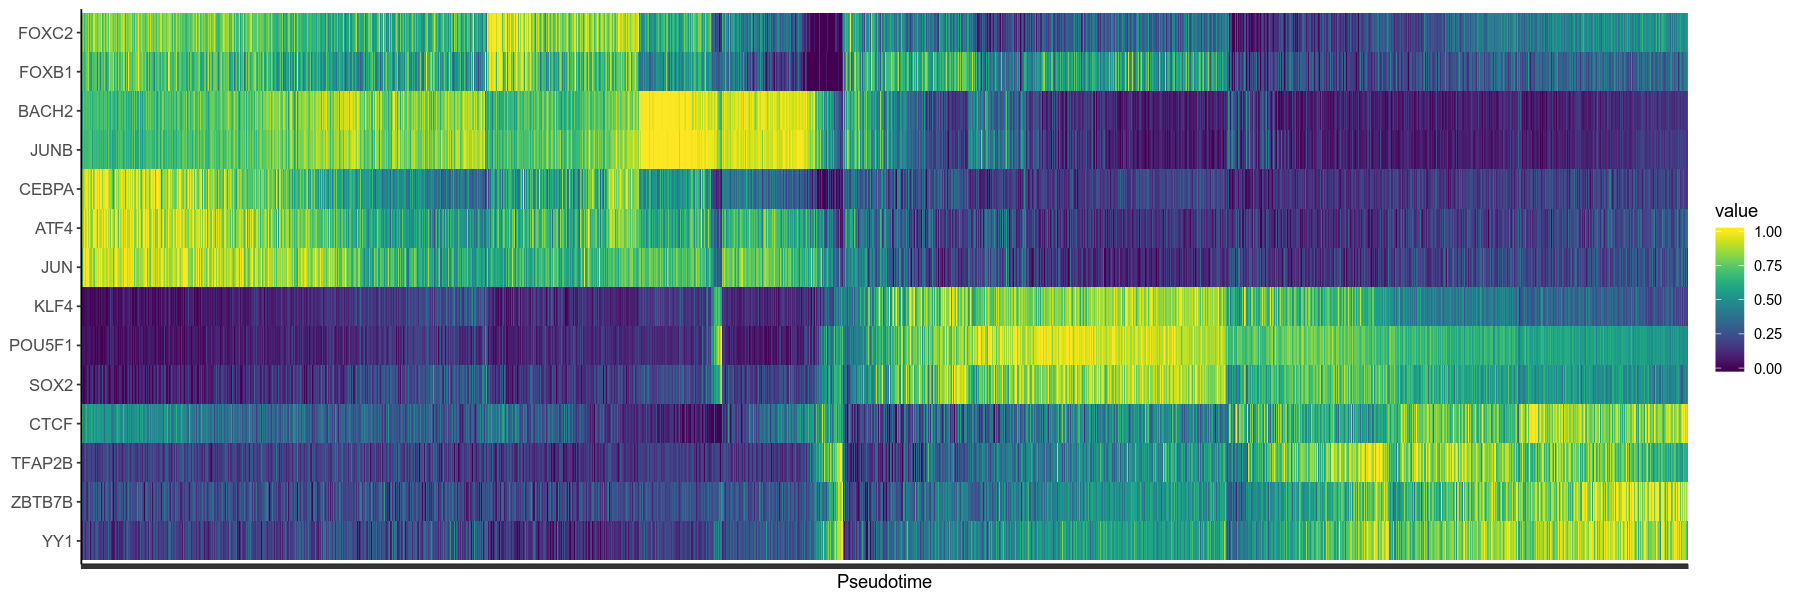

In [270]:
options(repr.plot.width = 15, repr.plot.height = 5)

ggplot(data = melted, mapping = aes(x = Var2,
                                    y = Var1,
                                    fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Pseudotime") +  
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(-1, 1), oob=squish, option = "B") +
# scale_fill_gradient(limits=c(-0.5,0.5), oob=squish, low="blue4", high="yellow") +
scale_fill_viridis(limits=c(0,1), oob=squish) +
# facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
theme_classic() +
theme(axis.text.x=element_blank(),
      axis.text.y=element_text(angle=0,hjust=1, size=10),
#       axis.ticks.y=element_blank(),
#       panel.spacing.y = unit(0.03, "cm"),
      strip.text.y = element_text(size = 3)) +
#       strip.background = element_rect(size = 0.1))

ggsave(sprintf("figs/%s_pluripotency_pseudotime_chromvar.jpeg", format(Sys.Date(), format='%Y%m%d')),
       width = 15, height = 5, dpi=300)